In [ ]:
# Processing the labels of the raw IMDB data

In [1]:
import os

In [2]:
imdb_dir = r'c:\Download\aclImdb'

In [3]:
train_dir = os.path.join(imdb_dir, 'test')

In [4]:
labels = []
texts = []

In [6]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [8]:
len(labels)

18546

In [9]:
len(texts)

18546

In [ ]:
# Tokenizing the text of the raw IMDB data

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [11]:
# Cuts off reviews after 100 words
maxlen = 100

In [12]:
# Trains on 200 samples
training_samples = 200

In [13]:
# Validates on 10,000 samples
validation_samples = 10000

In [14]:
# Considers only the top 10,000 words in the dataset
max_words = 10000

In [15]:
tokenizer = Tokenizer(num_words=max_words)

In [16]:
tokenizer.fit_on_texts(texts)

In [17]:
sequences = tokenizer.texts_to_sequences(texts)

In [18]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72745 unique tokens.


In [19]:
data = pad_sequences(sequences, maxlen=maxlen)

In [20]:
labels = np.asarray(labels)

In [21]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (18546, 100)
Shape of label tensor: (18546,)


In [22]:
# Splits the data into a training set and a validation set, but first shuffles the data,
# because you’re starting with data in which samples are ordered (all negative first, then
# all positive)

In [23]:
indices = np.arange(data.shape[0])

In [24]:
np.random.shuffle(indices)

In [25]:
data = data[indices]

In [26]:
labels = labels[indices]

In [27]:
x_train = data[:training_samples]
y_train = labels[:training_samples]

In [28]:
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [29]:
# Parsing the GloVe word-embeddings file

In [30]:
glove_dir = r'c:\Download\glove.6B'

In [31]:
embeddings_index = {}

In [34]:
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding="utf8")

In [35]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [36]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400004 word vectors.


In [37]:
# build an embedding matrix that you can load into an Embedding layer.

In [38]:
# It must be a matrix of shape (max_words, embedding_dim), where each entry i contains
# the embedding_dim-dimensional vector for the word of index i in the reference word
# index (built during tokenization)

In [39]:
# Preparing the GloVe word-embeddings matrix

In [40]:
embedding_dim = 100

In [41]:
embedding_matrix = np.zeros((max_words, embedding_dim))

In [42]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [43]:
# Words not found in the embedding index will be all zeros

In [44]:
# Model definition

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [46]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Loading pretrained word embeddings into the Embedding layer

In [48]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [49]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 150ms/step - loss: 1.6757 - accuracy: 0.6100 - val_loss: 0.7173 - val_accuracy: 0.7391
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.4883 - accuracy: 0.8200 - val_loss: 0.6047 - val_accuracy: 0.7331
Epoch 3/10
7/7 [==============================] - 1s 110ms/step - loss: 0.1474 - accuracy: 0.9800 - val_loss: 0.9083 - val_accuracy: 0.7392
Epoch 4/10
7/7 [==============================] - 1s 108ms/step - loss: 0.1113 - accuracy: 0.9850 - val_loss: 0.6197 - val_accuracy: 0.7324
Epoch 5/10
7/7 [==============================] - 1s 108ms/step - loss: 0.1346 - accuracy: 0.9550 - val_loss: 1.2546 - val_accuracy: 0.7389
Epoch 6/10
7/7 [==============================] - 1s 107ms/step - loss: 0.0676 - accuracy: 0.9750 - val_loss: 0.8718 - val_accuracy: 0.7389
Epoch 7/10
7/7 [==============================] - 1s 108ms/step - loss: 0.0310 - accuracy: 1.0000 - val_loss: 0.6291 - val_accuracy: 0.7208
Epoch 8/10
7/7 [====

In [51]:
model.save_weights('pre_trained_glove_model.h5')

In [52]:
# Plotting the results

In [53]:
import matplotlib.pyplot as plt

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [55]:
epochs = range(1, len(acc) + 1)

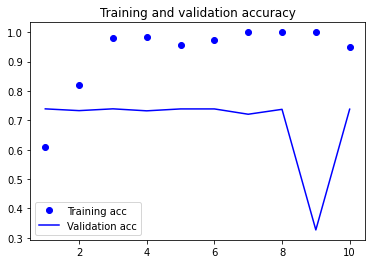

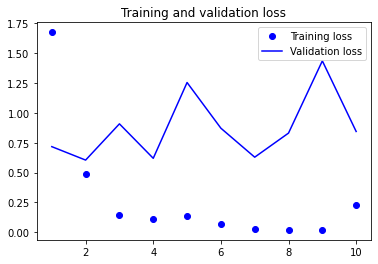

In [56]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()